# Baseline Modelling

## Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.model_selection import cross_val_score, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, make_scorer

from sentence_transformers import SentenceTransformer


In [3]:
import os
import sys
from pathlib import Path

path = Path(os.path.dirname(os.getcwd()))
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/saideepbunny/Projects/Application_Ranking_System


## Reading the data

In [4]:
df = pd.read_csv(f"{path}/data/synthetic_data/synthetic_data_v1.csv")
df

,job_data,resume_data,label
0,Master Scheduler\nBaltimore Aircoil Company (B...,# *John Miller*\n\n**Professional Summary**\n\...,Complete Mismatch
1,Master Scheduler\nBaltimore Aircoil Company (B...,# James Casey\n\n## Professional Summary\n\nHi...,Underwhelming
2,Master Scheduler\nBaltimore Aircoil Company (B...,# Rachel Vargas\n\n## Professional Summary\n\n...,Good Fit
3,Master Scheduler\nBaltimore Aircoil Company (B...,# Susan Bradley\n\n**Professional Summary**\n\...,Overqualified
4,Master Technician\nCompany / Location Informat...,# Sean Johnson\n\n## Professional Summary\n\nD...,Complete Mismatch
...,...,...,...
5995,Account Executive Digital Sales\nOverview\nSal...,# Todd Walters\n\n**Professional Summary**\n\n...,Overqualified
5996,"Account Executive, Industrial Equipment\nWith ...",**DOUGLAS BLAKE**\n\n**Professional Summary**\...,Complete Mismatch
5997,"Account Executive, Industrial Equipment\nWith ...",# Kyle Villegas\n\n## Professional Summary\n\n...,Underwhelming
5998,"Account Executive, Industrial Equipment\nWith ...",# Charles Preston\n\n**Professional Summary**\...,Good Fit


In [5]:
print("Number of rows in the dataset:", df.shape[0])
print("Number of columns in the dataset:", df.shape[1])

Number of rows in the dataset: 6000
Number of columns in the dataset: 3


In [6]:
df['label'].value_counts()

label
Complete Mismatch    1518
Underwhelming        1499
Good Fit             1498
Overqualified        1485
Name: count, dtype: int64

## Data preprocessing

In [7]:
# Download stopwords if not already downloaded
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stop_words.add("overqualified")
stop_words.add("underqualified")
stop_words.add("mismatch")
stop_words.add("good")
print(stop_words)

{"wasn't", 'he', 'ain', "they've", 'so', 'd', "it'll", 'before', "shan't", 'doing', "hadn't", 'me', 'ours', 'being', 'of', 'that', "that'll", "they're", 'overqualified', 'all', 'didn', 'those', 'how', 'our', "couldn't", 'shouldn', 'has', 'off', 'had', 'on', 'or', 'nor', 'own', "isn't", 'most', "she'll", 'the', 'this', 've', 'against', "you've", 'an', 'been', 'here', 'too', 'wasn', 'don', 'other', 'below', "hasn't", "he's", 'when', "should've", 'while', 'not', 'is', "it'd", 'as', 'but', 'doesn', 's', 'weren', 'will', 're', 'some', "he'll", 'mismatch', 'my', 'wouldn', 'them', 'yours', "haven't", 'having', 'aren', 'these', 'they', "i'm", 'down', "we've", 'his', 'yourself', 'until', 'once', 'needn', "shouldn't", 'than', "won't", 'myself', 'into', 'were', 'there', 'now', "you'll", 'under', 'over', 'hers', 'did', 'same', "she's", "you're", 'theirs', 'by', 'hadn', 'y', "he'd", "weren't", 'during', 'out', "they'll", "they'd", 'any', 'up', 'because', 'can', 'if', "i'd", "you'd", "i'll", 'which'

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saideepbunny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove unwanted symbols except %, $, /, and .
    text = re.sub(r"[^a-z0-9\s%$/.-]", "", text)

    # Preserve hyphens only when followed by a number (e.g., 2005-2010, 2010-present)
    text = re.sub(r"-(?!\d)", "", text)  # Remove hyphens not followed by a digit

    # Preserve GPA-like formats (e.g., 3.8/4.0)
    text = re.sub(r"(?<!\d)/|/(?!\d)", " ", text)  # Remove '/' unless between numbers

    # Remove periods (".") if they are immediately after a word but not numbers (e.g., "good." → "good", but keep 3.8)
    text = re.sub(r"\b(\w+)\.(?!\d)", r"\1", text)

    # Remove newline characters
    text = text.replace("\n", " ").replace("\r", " ")

    # Remove any show less and show more texts
    text = text.replace("show less", "").replace("show more", "")
    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    text = " ".join(word for word in text.split() if word not in stop_words)

    return text

In [9]:
df['job_data_preprocessed'] = df['job_data'].apply(preprocess_text)
df['resume_data_preprocessed'] = df['resume_data'].apply(preprocess_text)

In [10]:
print(df.iloc[1]['job_data'])
print("\n******************************************************\n")
print(df.iloc[1]['job_data_preprocessed'])

Master Scheduler
Baltimore Aircoil Company (BAC), an Amsted Industry, is a proudly employee-owned, equal-opportunity company who is committed to upholding a diverse, inclusive culture that thrives on teamwork and a spirit of enterprise. We are the global leader in sustainable solutions for evaporative cooling, thermal storage, and heat transfer equipment with headquarters located in Jessup, Maryland and manufacturing located in Madera, CA, Milford, DE and Dayton, TN. The Master Scheduler, BAC Dayton is a key member of the Dayton, Tennessee Supply Chain Team, to include Baltimore Aircoil Company (BAC) and Coil Design operations. If you want to make an impact, have a sense of belonging and a desire to grow. Every reason to join us begins with YOU!
POSITION PURPOSE
The Master Scheduler, BAC Dayton is a key member of the Dayton, Tennessee Supply Chain Team, to include Baltimore Aircoil Company (BAC) and Coil Design operations. Role manages the daily plant supply chain operations to maximiz

In [11]:
print(df.iloc[1]['resume_data'])
print("\n******************************************************\n")
print(df.iloc[1]['resume_data_preprocessed'])

# James Casey

## Professional Summary

Highly motivated and detail-oriented professional with experience in operations and supply chain management. Proven track record of managing production control, manufacturing scheduling, and safety initiatives. Seeking to leverage my skills and experience to contribute to a dynamic team as a Master Scheduler.

## Skills

Operations, Supply Chain, MRP systems, Master scheduling, Production control, Manufacturing scheduling, Safety, Quality, Operations performance, Ownership, Urgency, Sales orders, Master schedule, Supply needs, Staffing needs, Load leveling, Bottleneck scheduling, Operations input, Output reporting, Sales & operations planning, Communication, Teamwork, Leadership, Capacity management, Layered manufacturing, Organization, Interpersonal skills, Analytical skills, Follow-up skills, Initiative, Attention to detail, Microsoft Office, Excel, Lean Manufacturing Methodologies, JIT concepts, Business, Operations Management, Accounting

## 

## Modelling: Sentence Embeddings

### Utility functions

In [12]:
def cross_validation_scores(model, X, y, n_splits=5):
    # Define k-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    
    # Print results
    print(f"Cross-validation scores: {scores}")
    print(f"Mean accuracy: {scores.mean():.4f}")
    print(f"Standard deviation: {scores.std():.4f}")
    
    
def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    """
    Displays a confusion matrix using seaborn heatmap.

    Parameters:
    y_true : list or array
        True labels.
    y_pred : list or array
        Predicted labels.
    labels : list, optional
        Class labels for the confusion matrix.
    title : str, optional
        Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()


def chunk_text(text, max_length=512, overlap=50):
    """
    Splits text into overlapping chunks.
    """
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_length - overlap):
        chunk = " ".join(words[i:i+max_length])
        chunks.append(chunk)
        if i + max_length >= len(words):
            break
    return chunks

def get_text_embedding(text, model):
    """
    Converts large text into embeddings using chunking + mean pooling.
    """
    chunks = chunk_text(text)
    embeddings = model.encode(chunks, convert_to_numpy=True)  # Get embeddings
    return np.mean(embeddings, axis=0)  # Aggregate embeddings using mean pooling

### Generating embeddings

In [13]:
embedding_df = pd.DataFrame()

# Load a Transformer model
embedding_model = SentenceTransformer('all-mpnet-base-v2') #768 dimension vector space


In [14]:
# Compute embeddings
overall_data = "Job Description:\n" + df['job_data_preprocessed'] + "\nResume:\n" + df['resume_data_preprocessed'] 
overall_d1 = overall_data.apply(lambda x: get_text_embedding(x, embedding_model))

embedding_df = pd.DataFrame(overall_d1.tolist(), index=df.index, columns = [f"f_{i+1}" for i in range(len(overall_d1.tolist()[0]))])
embedding_df

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767,f_768
0,0.018428,0.029744,-0.029598,0.020638,-0.002045,0.024787,-0.000230,0.030693,-0.032532,-0.034612,...,0.002223,-0.005173,-0.025733,0.027371,-0.024355,-0.017763,-0.011107,-0.009124,0.006882,-0.027897
1,0.021307,0.021493,-0.036527,0.010626,0.010570,0.031550,0.024833,0.017546,-0.052825,-0.036968,...,0.008675,-0.004230,-0.033390,0.028432,-0.019858,0.000580,0.003700,0.000010,-0.046121,-0.040561
2,0.011452,0.016750,-0.042194,0.003188,0.008405,0.004845,0.022481,0.009291,-0.050268,-0.025193,...,0.021842,-0.000587,-0.017207,0.019057,-0.015288,0.013859,-0.004045,0.000730,-0.039691,-0.046043
3,0.015665,0.001300,-0.038212,0.003785,0.014372,0.020898,0.028037,0.018895,-0.057002,-0.032166,...,0.011852,0.010193,0.009997,0.019825,-0.018690,-0.017523,-0.011263,-0.002338,-0.040661,-0.042966
4,0.015209,0.014843,-0.030631,-0.010830,-0.006648,0.025149,-0.005646,0.034000,-0.018253,-0.023902,...,-0.011883,0.003671,-0.013184,0.021477,-0.005643,0.002305,0.002030,-0.015366,0.022123,-0.023859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,0.075150,0.068498,-0.030138,-0.054559,0.018980,0.005732,0.027167,-0.000290,-0.036058,-0.076405,...,0.006502,0.008733,-0.044143,0.041533,-0.022989,-0.024925,-0.016434,-0.011162,0.029791,-0.029931
5996,0.045434,0.065664,-0.028174,-0.038250,0.020036,0.035680,-0.016634,0.020833,-0.024164,-0.024964,...,-0.000115,0.000700,-0.038505,0.044218,-0.015787,0.030061,-0.019183,-0.006678,0.038340,-0.036816
5997,0.053587,0.038829,-0.031973,-0.036432,0.030304,0.002427,-0.001389,-0.009611,-0.020060,-0.074911,...,0.001593,0.006102,-0.008557,0.027873,-0.016664,-0.019409,-0.014764,-0.014005,0.015960,-0.029828
5998,0.037198,0.057212,-0.030077,-0.017417,0.007491,-0.006065,-0.019598,0.004696,-0.040753,-0.078779,...,-0.025979,0.017489,0.000180,0.023178,0.009362,0.008642,-0.008427,-0.024600,0.006933,-0.025316


### Defining X and y

In [15]:
# Stack embeddings horizontally
X = embedding_df.copy()
y = df['label']

### Train Test split

In [16]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 768)
Test data shape:  (1200, 768)


### DecisionTreeClassifier

In [17]:
model_4class = DecisionTreeClassifier(random_state=42)  # Example model
cross_validation_scores(model_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.34479167 0.328125   0.34270833 0.3625     0.35416667]
Mean accuracy: 0.3465
Standard deviation: 0.0116


In [18]:
# Train model on full training set
model_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = model_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.57      0.55      0.56       304
         Good Fit       0.23      0.24      0.24       299
    Overqualified       0.26      0.27      0.26       297
    Underwhelming       0.32      0.30      0.31       300

         accuracy                           0.34      1200
        macro avg       0.34      0.34      0.34      1200
     weighted avg       0.35      0.34      0.34      1200


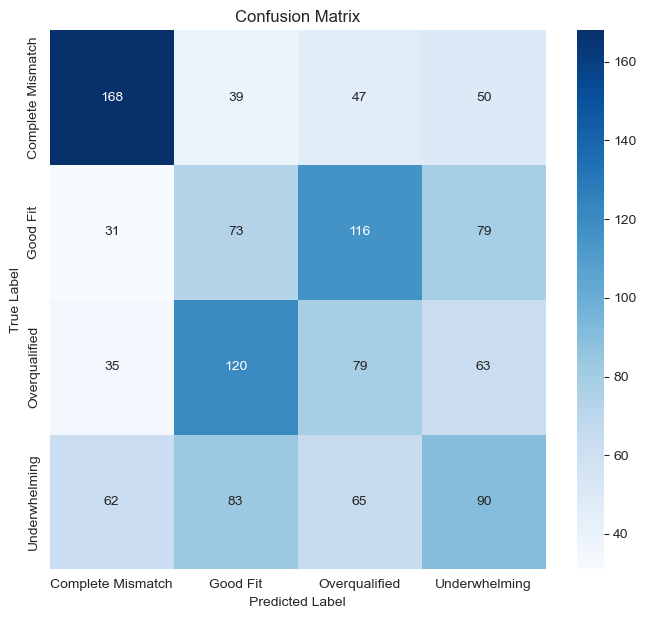

In [19]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### RandomForestClassifier

In [20]:
model_4class = RandomForestClassifier(random_state=42)  # Example model
cross_validation_scores(model_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.390625   0.390625   0.38854167 0.40833333 0.39270833]
Mean accuracy: 0.3942
Standard deviation: 0.0072


In [21]:
# Train model on full training set
model_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = model_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
                   precision    recall  f1-score   support

Complete Mismatch       0.76      0.79      0.77       304
         Good Fit       0.11      0.13      0.12       299
    Overqualified       0.17      0.16      0.17       297
    Underwhelming       0.37      0.32      0.34       300

         accuracy                           0.35      1200
        macro avg       0.35      0.35      0.35      1200
     weighted avg       0.36      0.35      0.35      1200


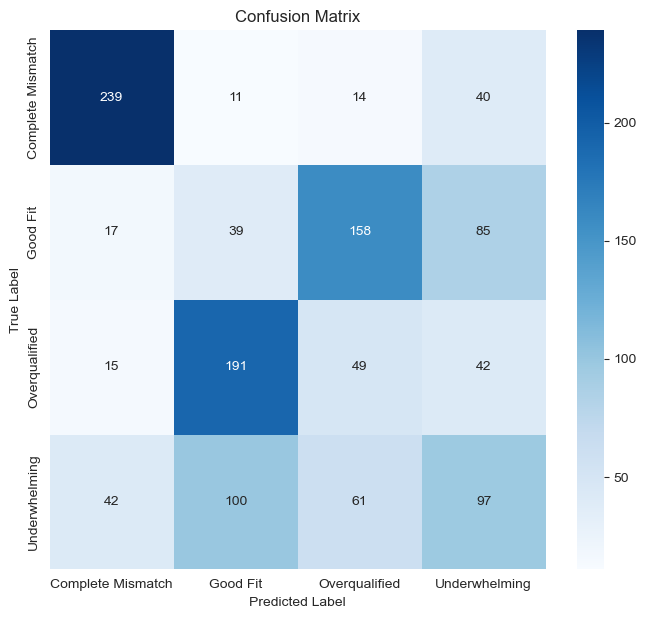

In [22]:
plot_confusion_matrix(y_test, y_pred, ["Complete Mismatch", "Good Fit", "Overqualified", "Underwhelming"])

### XGBClassifier : Multi class classification

In [23]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_42888/3337498069.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":1, "Good Fit":2, "Overqualified":3})


In [24]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 768)
Test data shape:  (1200, 768)


In [25]:
xgb_4class = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(xgb_4class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.44479167 0.46354167 0.48645833 0.459375   0.46458333]
Mean accuracy: 0.4637
Standard deviation: 0.0134


In [26]:
# Train model on full training set
xgb_4class.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_4class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83       303
           1       0.49      0.47      0.48       300
           2       0.21      0.23      0.22       300
           3       0.29      0.28      0.28       297

    accuracy                           0.45      1200
   macro avg       0.46      0.45      0.46      1200
weighted avg       0.46      0.45      0.46      1200


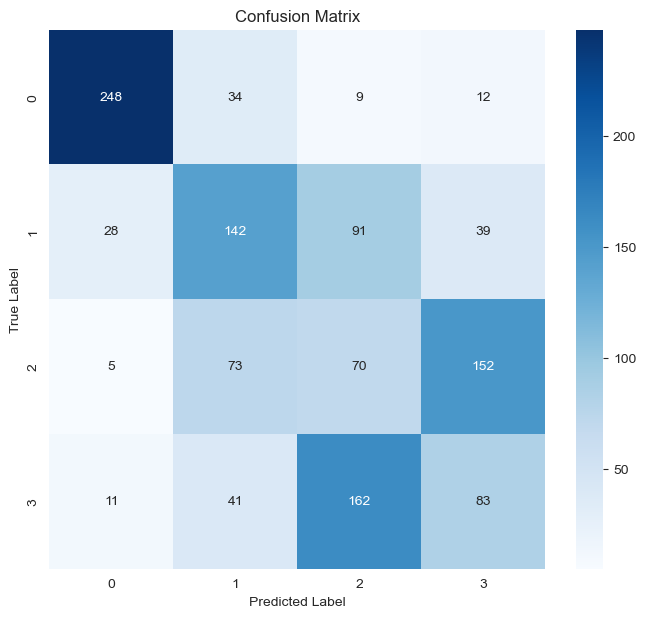

In [27]:
plot_confusion_matrix(y_test, y_pred, [0, 1, 2, 3])

### XGBClassifier : Binary Classification

- Complete Mismatch and Underwhelming are bad fits (0)
- Good fit and Overqualified are good fits (1)

In [28]:
X = embedding_df.copy()
y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})

/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_42888/2897412205.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['label'].replace({"Complete Mismatch": 0, "Underwhelming":0, "Good Fit":1, "Overqualified":1})


In [29]:
# Assuming X contains features and y contains labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

print("Train data shape: ", X_train.shape)
print("Test data shape: ", X_test.shape)

Train data shape:  (4800, 768)
Test data shape:  (1200, 768)


In [30]:
xgb_2class = XGBClassifier(random_state=42)  # Example model
cross_validation_scores(xgb_2class, X_train, y_train, n_splits=5)

Cross-validation scores: [0.78541667 0.77708333 0.76041667 0.796875   0.77395833]
Mean accuracy: 0.7787
Standard deviation: 0.0121


In [31]:
# Train model on full training set
xgb_2class.fit(X_train, y_train)

# Evaluate on test set
y_pred = xgb_2class.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       603
           1       0.80      0.84      0.82       597

    accuracy                           0.82      1200
   macro avg       0.82      0.82      0.82      1200
weighted avg       0.82      0.82      0.82      1200


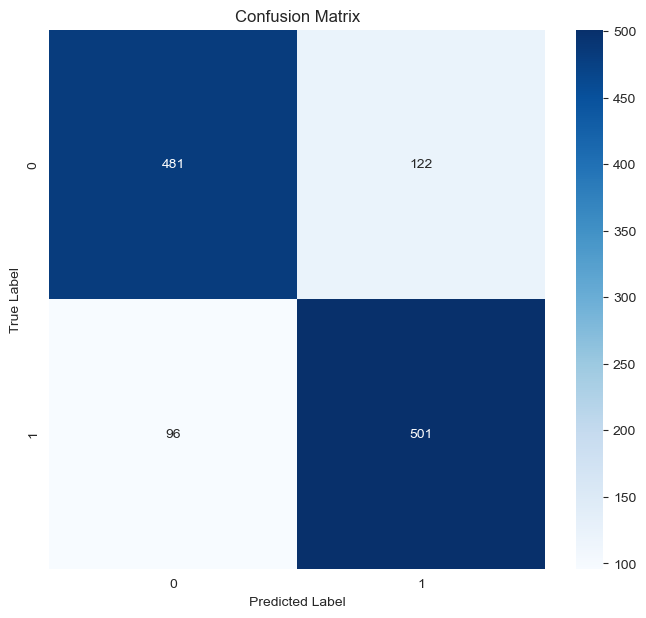

In [32]:
plot_confusion_matrix(y_test, y_pred, [0, 1])

In [33]:
rd="""
A Data Scientist with 3 years of experience in developing machine learning pipelines and models to address business needs. Also
experienced in communicating insights to enhance strategic decision-making and improve performance outcomes.
EDUCATION
Master Of Science In Data Science
Northeastern University | GPA: 3.93 / 4.00 Portland, Maine | Sep 2023
- May 2025
Bachelor Of Technology In Computer Science
Vardhaman College of Engineering | GPA: 8.84 / 10.00 Hyderabad | May 2017
- Jun 2021
WORK EXPERIENCE
Data Engineer Co-Op | Full-time Jul 2024
- Present
EAI at Northeastern University
• Engineered an end-to-end claim complexity scoring ML pipeline for MEMIC, negating ~3 minutes of mannual classification per claim.
• Developed a robust claim complexity scoring model and reduced false negatives by 20%, streamlining the Claim Assignment Engine's efficiency within 6 months.
• Identified an issue with prediction validation, which led to employing advanced testing validated by statistical tests.
• Revised the existing claim assignment process to automatically assign claims classified by scoring engine to agents by prioritizing highly complex claims, achieving 100% automation.
• Communicated weekly insights to clients, enhancing strategic decision-making and improving performance outcomes through
experimental findings and suggesting actionable plans.
Azure Data Engineer | Full-time Aug 2021
- Jul 2023
LTIMindtree
• Resolved customer issues from Azure cloud services with an average solution acceptance rate of 50%, consistently for over one year.
• Utilized Azure Databricks data engineering environment to solve business problems for customers and improve data quality by 35%.
• Automated ETL pipelines for big data extraction and processing using Data factory and Dataflows, reducing processing time by 40%.
• Recognized as a highly motivated member of Azure Collective on Stack Overflow, contributing 404 answers and reaching 428k people.
• Developed a Question Moderator Model that improved question validation efficiency, saving 10% of time monthly by minimizing
invalid question engagement.
PROJECTS
Application Ranking System Sep 2024
- Apr 2025
• Built an AI-powered Application Ranking System using cosine similarity, FAISS, and a custom scoring formula for efficient ranking.
Aims to improve hiring by reducing bias, rewarding well-crafted resumes, and offering a fair ranking system for job applications.
Stance Detection Model Using Generative AI
• Developed a Huggingface space using fine-tuned text classification LLM to detect the stance using manually labeled and synthetic data.
Leveraged LoRA fine-tuning to train only ~1% of LLM's parameters in Roberta base model's architecture to achieve 0.80 accuracy.

SKILLS
Programming: Python, SQL Server, Java, Data Structures and Algorithms, Problem-
solving skills
Machine Learning: Machine Learning, Regression, Classification, Data Cleaning, Data preprocessing, Data transformation, Feature
Engineering, Data Visualization, XGBoost, Cross Validation, Deep learning, Neural Networks, Natural Language Processing, Transformers,
Sentiment Analysis, Huggingface, Large Language models, Fine tuning, Prompt Engineering, Generative AI, RAG, Agentic AI
Libraries: NumPy, Pandas, Matplotlib, Scikit-
Learn, xgboost, SciPy, spaCy, Pytorch, Tensorflow, Optuna, Langchain, ollama, transformers
Others: Jupyter, Azure, Git, SSMS, PowerBI, Microsoft Excel, Databricks, PySpark, Documentation, Statistical analysis
"""

jd="""
Construction project engineer
JARDINE is a premier construction management and general contracting firm based in Centerville, Utah. We specialize in commercial construction with a focus on historic renovations, mountain and resort construction, light industrial projects, pharmaceutical and nutraceutical facilities, clean rooms, lab spaces, retail environments, food & beverage spaces, and tenant improvements. Our approach prioritizes collaborative project delivery methods such as Construction Management/General Contracting, Design-Build, Design Assist, and Cost-Plus to ensure successful project outcomes.

Role Description
JARDINE is seeking a full-time, on-site Construction Project Engineer to join our team in the Salt Lake City Metropolitan Area. This role is instrumental in supporting project execution, ensuring smooth coordination between field teams, subcontractors, and project management. The Construction Project Engineer will be actively involved in project coordination, construction engineering, RFI's, submittals, and communication to drive project success.

Key Responsibilities
Project Coordination: Support project managers and field teams in scheduling, logistics, and workflow efficiency.
Construction Engineering: Assist in design reviews, constructability analysis, and technical problem-solving.
Quality Control: Ensure compliance with project specifications, safety standards, and best practices.
Submittals & RFIs: Prepare, track, and manage submittals, RFIs, and change orders throughout the project lifecycle.
Communication: Maintain clear and effective communication between project stakeholders, including subcontractors, suppliers, and clients.
Documentation & Reporting: Keep detailed records of project progress, budgets, and schedules using construction management software.
Qualifications
Strong project coordination and construction engineering skills.
Experience in RFI and submittal processes.
Excellent written and verbal communication skills.
Proficiency in construction project management software (e.g., Procore, Bluebeam, MS Project).
Ability to read and interpret construction drawings and specifications.
Bachelor’s degree in Construction Management, Civil Engineering, or a related field.
Relevant certifications such as PE (Professional Engineer) or PMP (Project Management Professional) are a plus.
Why Join JARDINE?
Competitive salary based on experience.
Health benefits, 401(k), and paid time off.
Opportunities for career growth and professional development.
A collaborative, team-oriented work environment.

Project Coordination, Construction Engineering, RFI Process, Submittals Management, Quality Control, Scheduling, Logistics, Workflow Efficiency, Constructability Analysis, Technical Problem-Solving, Compliance with Safety Standards, Change Order Management, Stakeholder Communication, Documentation, Reporting, Construction Management Software (Procore, Bluebeam, MS Project), Construction Drawings Interpretation, Budget Tracking, Civil Engineering, Construction Management, Project Management, Professional Certifications (PE, PMP).
"""

In [34]:
real_df = pd.DataFrame([{"job_data":jd, "resume_data":rd}])
real_df

,job_data,resume_data
0,\nConstruction project engineer\nJARDINE is a ...,\nA Data Scientist with 3 years of experience ...


In [35]:
print(real_df.iloc[0]['resume_data'])


A Data Scientist with 3 years of experience in developing machine learning pipelines and models to address business needs. Also
experienced in communicating insights to enhance strategic decision-making and improve performance outcomes.
EDUCATION
Master Of Science In Data Science
Northeastern University | GPA: 3.93 / 4.00 Portland, Maine | Sep 2023
- May 2025
Bachelor Of Technology In Computer Science
Vardhaman College of Engineering | GPA: 8.84 / 10.00 Hyderabad | May 2017
- Jun 2021
WORK EXPERIENCE
Data Engineer Co-Op | Full-time Jul 2024
- Present
EAI at Northeastern University
• Engineered an end-to-end claim complexity scoring ML pipeline for MEMIC, negating ~3 minutes of mannual classification per claim.
• Developed a robust claim complexity scoring model and reduced false negatives by 20%, streamlining the Claim Assignment Engine's efficiency within 6 months.
• Identified an issue with prediction validation, which led to employing advanced testing validated by statistical tests

 True label is assigned based on the understanding.

- Above resume is a complete mismatch to Site Reliability Engineer, because it is completely different skill and expertise requirement.
- Above resume is an Underwhelming to Data Scientist L4, because it is the same core area but the resume lacks key skills required like A/B testing.
- Above resume is a good fit for Data Scientist requiring similar expertise and experience.
- Above resume is an overqualified fit for the Data Engineer position which required skills that are far less compared to what the candidate possess

In [40]:
real_df['job_data_preprocessed'] = real_df['job_data'].apply(preprocess_text)
real_df['resume_data_preprocessed'] = real_df['resume_data'].apply(preprocess_text)

# Compute embeddings
combined_data = "Job Description:\n" + real_df['job_data_preprocessed'] + "\nResume:\n" + real_df['resume_data_preprocessed'] 
combined_d1 = combined_data.apply(lambda x: get_text_embedding(x, embedding_model))

edf = pd.DataFrame(combined_d1.tolist(), index=real_df.index, columns = [f"f_{i+1}" for i in range(len(combined_d1.tolist()[0]))])
edf

,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,f_10,...,f_759,f_760,f_761,f_762,f_763,f_764,f_765,f_766,f_767,f_768
0,0.02746,0.074395,-0.044027,-0.020334,0.015358,0.010736,-0.013945,0.002697,-0.052822,-0.023759,...,-0.01144,0.003331,-0.016823,0.028028,-0.008,-0.033974,-0.028421,-0.004494,0.002082,-0.03323


### Results

In [41]:
print("Predicted category for 4-category classification: ",xgb_4class.predict(edf))
print("Predicted probabilities for 4-category classification: ",xgb_4class.predict_proba(edf))

Predicted category for 4-category classification:  [2]
Predicted probabilities for 4-category classification:  [[0.00829086 0.01819922 0.76907605 0.20443384]]


In [42]:
xgb_4class.predict_proba(edf)

array([[0.00829086, 0.01819922, 0.76907605, 0.20443384]], dtype=float32)

#### Two Class prediction

Expected output is 0 : Bad

In [43]:
print("Predicted category for 2-category classification: ",xgb_2class.predict(edf))
print("Predicted category for 2-category classification: ",xgb_2class.predict_proba(edf))

Predicted category for 2-category classification:  [1]
Predicted category for 2-category classification:  [[0.07921147 0.9207885 ]]


In [44]:
xgb_2class.predict_proba(edf)

array([[0.07921147, 0.9207885 ]], dtype=float32)